# Overview :


## **Financial Time-Series Analysis and Advanced Modeling**

In this project  we explore the domain of financial time-series analysis. covering foundational concepts and advancing towards state of the art modeling techniques. our objective is to gain insights and make data driven forecasts by leveraging both traditional statistical methods and modern deep learning approaches. The key highlights of this notebook include:

1. **Introduction to Financial Time-Series Data**:
   - Understanding components like trends, seasonality, cycles, and noise in data such as stock prices like gold (XAU/USD)
   - Discussing unique behaviors of financial markets  including volatility and autocorrelation.

3. **Exploratory Data Analysis (EDA)**:
   - Visualizing trends, seasonality, and autocorrelation using tools like ACF and PACF plots.
   - Detecting periodic patterns and volatility clustering.

2. **Data Preprocessing**:
   - Handling missing values, outliers, and transformations like scaling and log transformations.
   - Feature Engineering : add some new features (Like technical Indicators )

4. **Statistical Models**:
   - Applying classical models such as ARIMA, SARIMA, and exponential smoothing for baseline forecasts.

5. **Advanced Machine Learning Models**:
   - Implementing models like Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRU) to capture non-linear patterns.
   - Combining machine learning approaches with exogenous variables for improved predictions.

6. **Darts Library**:
   - Demonstrating how to utilize the Darts library for efficient time-series analysis, covering features like forecasting, model selection, and evaluation.





# 1- Setup

### Import Dependencies

In [74]:
from IPython.display import clear_output

In [ ]:
!pip install pandas_ta
!pip install darts
!pip install yfinance==0.2.47

clear_output()

In [76]:
#linear algebra and data
import numpy as np
import pandas as pd
import pandas_ta as ta
#visulization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


#igore warings
import warnings
warnings.filterwarnings("ignore")
#machine learning


#darts library
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mape, rmse, mae
from darts.dataprocessing.transformers import Scaler
from darts.models import  RNNModel
from darts.models import (
    TCNModel,
    TransformerModel,
    TiDEModel
)

### Configs

In [77]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

from google.colab import output
output.enable_custom_widget_manager()

### Constans And Parameters

In [78]:
DATASET_PATH = "/content/XAU-USD-2018-2024.csv"

START_DATE = '2022-01-01'
END_DATE = '2024-11-15'

# 2- Load Data

In [152]:
df = pd.read_csv(DATASET_PATH)

#set date as index in dataframe (because we have time-series data to work on)
df["Date"] = pd.to_datetime(df["Date"])
df = df[(df["Date"]>=START_DATE) & (df["Date"]<=END_DATE) ]

df.set_index("Date", inplace=True)
df.sort_index(inplace=True)


df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-01-03,"1,800.85","1,830.14","1,832.06","1,797.93",NaN,-1.51%
2022-01-04,"1,814.56","1,801.34","1,816.83","1,798.44",NaN,0.76%
2022-01-05,"1,809.53","1,814.90","1,829.82","1,807.97",NaN,-0.28%
2022-01-06,"1,788.68","1,809.94","1,811.89","1,786.03",NaN,-1.15%
2022-01-07,"1,795.63","1,789.55","1,799.20","1,782.63",NaN,0.39%


### Dataset Description :
  
1. **Features**:
   - **Open**: opening price of the trading day.
   - **High**: highest price during the trading day.
   - **Low**: lowest price during the trading day.
   - **Close**: closing price of the trading day.

2. **Target Variable**:
   - **Next Day Price**: closing price of the stock on the following trading day

3. **Time Period**:
   - The dataset spans from 01/01/2018 to    21/11/2024  of daily market data.



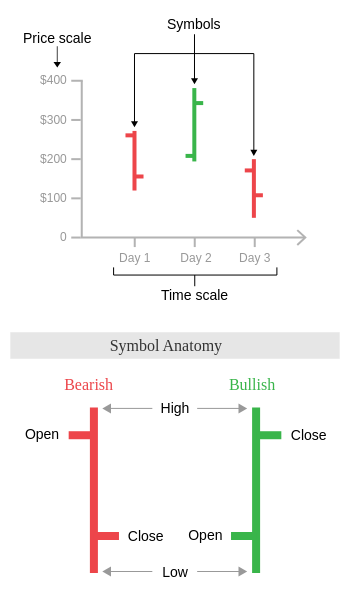

### Drop Useless Columns and Handle Data Fromat

In [153]:
#drop volumne (because it's null and we do not need it here )
df.drop([ 'Vol.'],inplace=True,axis=1)

columns = df.columns
columns

Index(['Price', 'Open', 'High', 'Low', 'Change %'], dtype='object')

In [154]:
#convert format of data ( from string to float)
for column in columns:
    df[column] = df[column].str.replace(',', '')
    df[column] = df[column].str.replace('%', '')
    df[column] = df[column].astype(float)

### Basic Descriptive Statistics

In [155]:
df.describe()

,Price,Open,High,Low,Change %
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,2019.623302,2019.097299,2033.343663,2006.078275,0.049171
std,266.972277,266.227884,268.488869,264.300371,0.899403
min,1621.570000,1621.990000,1641.320000,1614.350000,-3.490000
25%,1835.580000,1835.752500,1846.380000,1823.695000,-0.480000
50%,1945.870000,1945.310000,1960.125000,1935.175000,0.050000
75%,2067.675000,2065.537500,2085.542500,2058.562500,0.540000
max,2786.190000,2787.750000,2790.410000,2770.650000,3.590000


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2022-01-03 to 2024-11-15
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     748 non-null    float64
 1   Open      748 non-null    float64
 2   High      748 non-null    float64
 3   Low       748 non-null    float64
 4   Change %  748 non-null    float64
dtypes: float64(5)
memory usage: 35.1 KB


# 3- Data Visulization

### Basic Visulization Of Our Data And Features ( Open,Close and ... prices)

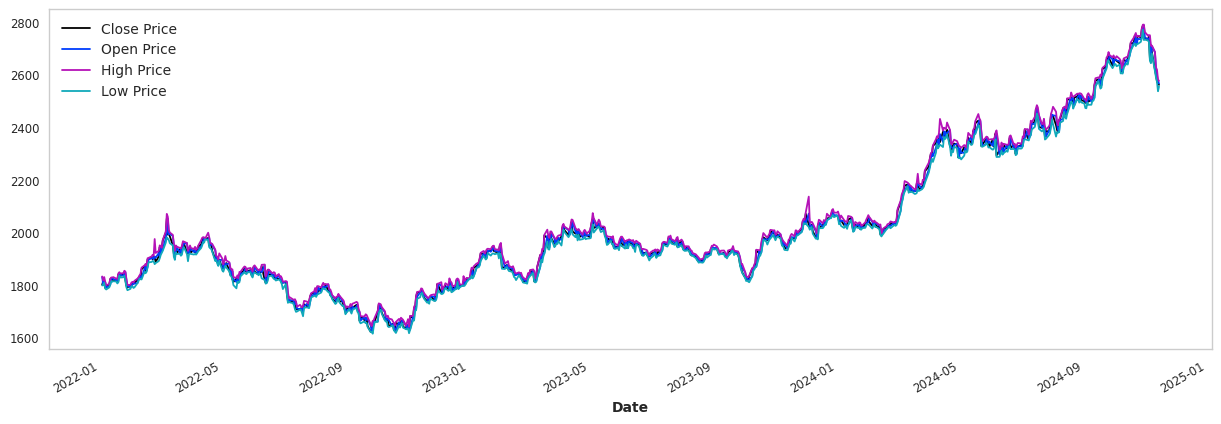

In [157]:
df.Price.plot(figsize=(15,5),label="Close Price")
df.Open.plot(figsize=(15,5),label="Open Price")
df.High.plot(figsize=(15,5),label="High Price")
df.Low.plot(figsize=(15,5),label="Low Price")
plt.grid(False)
plt.legend()

In [158]:
#show candle stick chart using plotly
fig = go.Figure(
    data = go.Candlestick(
        x=df.index,
        open=df["Open"],
        high=df["High"],
        low=df["Low"],
        close=df["Price"],
        title="Stock OHLC Candlestick Chart"
    )
)
fig

# 4- Data Preprocess

### **Resampling in Time Series Data:**

resampling is a method in time series analysis where we change the frequency of data points to gain additional insights or make the data easier to analyze. This process is essential for handling unevenly spaced data or smoothing trends  and addressing missing data


### **Types of Resampling**
1. **Upsampling**:  Increases the frequency of data points ( from daily to hourly)

2. **Downsampling**:Decreases the frequency of data points (  from daily to weekly)


### **Leverage Resampling to Address Missing Days**
 when there are missing days in a time series, resampling can help identify these gaps and allow you to fill them appropriately:
  1. **Detect Missing Days**:
     - we will use  .resample()  to specify the desired frequency (  daily data with  resample('D') )

     - Missing days will appear as NaN (not-a-number) values in the resampled dataset



### Checking For Missing Values with Resampling Data into Daily TimeFrame :
##### Resampling Can Findout Are There Any Missing Days ( From 1-1-2018 to 21-11-2024) in our Data Or Not



In [159]:
df_daily = df.resample("B").mean()
df_daily.head()

,Price,Open,High,Low,Change %
Date,,,,,
2022-01-03,1800.85,1830.14,1832.06,1797.93,-1.51
2022-01-04,1814.56,1801.34,1816.83,1798.44,0.76
2022-01-05,1809.53,1814.90,1829.82,1807.97,-0.28
2022-01-06,1788.68,1809.94,1811.89,1786.03,-1.15
2022-01-07,1795.63,1789.55,1799.20,1782.63,0.39


"B" in resample("B") stands for “Business Day”. This means that the data will be resampled to reflect only business days (Monday to Friday) excluding weekends and public holidays

In [160]:
df_daily.isna().sum()

,0
Price,2
Open,2
High,2
Low,2
Change %,2



### **Common Methods to Handle Missing Values in Time Series**

##### **1. Interpolation-Based Methods**:
- **Linear Interpolation**: Estimates missing values based on a straight line between known data points
- **Polynomial Interpolation**: Fits a polynomial curve to predict missing values
- **Spline Interpolation**: Uses piecewise polynomials to interpolate missing data more smoothly
- **Time-Based Interpolation**: Accounts for time intervals in interpolation

##### **2. Imputation Methods**:
- **Forward Fill**: Propagates the last valid observation forward
- **Backward Fill**: Propagates the next valid observation backward
- **Rolling Statistics**: Replaces missing values with a rolling mean or  median or other statistics over a specified window.


##### As You can See We Missed 5 Days in Our Data : we will use  Rolling Mean  or Moving Average (Mean of n last days) with Samll Time Period  

In [161]:
# using rolling mean to impute missing values
df_daily = df.fillna(df.rolling(3, min_periods=1,axis=0).mean(),axis=0)
#you can use interpolation too
#df = df.interpolate(method='linear')
# time based interpolation
#df = df.interpolate(method='time')

df_daily.isna().sum()

,0
Price,0
Open,0
High,0
Low,0
Change %,0


### Time-Series Components and Properties :
time-series data exhibits specific behaviors or patterns which commonly referred to as Components of the time series  these components describe the underlying structure of the data and help in understanding and modeling it  

### **Components And Properties of Time-Series Data**
1. **Trend**: A long-term increase or decrease in the data values. It represents the overall direction in which the data is moving over time.
   

2. **Seasonality**: Regular and predictable patterns that repeat over a fixed period [  daily, weekly,..]

3. **Cyclic Patterns**: Fluctuations that occur over long  irregular periods, often influenced by economic or business cycles.

4.  **Noise**: Random variations or residual patterns that cannot be explained by trend, seasonality, or cyclic behavior.

5. **Stationarity**: A stationary time series has constant statistical properties [mean, variance] over time with no trend or seasonality.
   

6. **Autocorrelation**: The relationship between a time series and its lagged values.
   


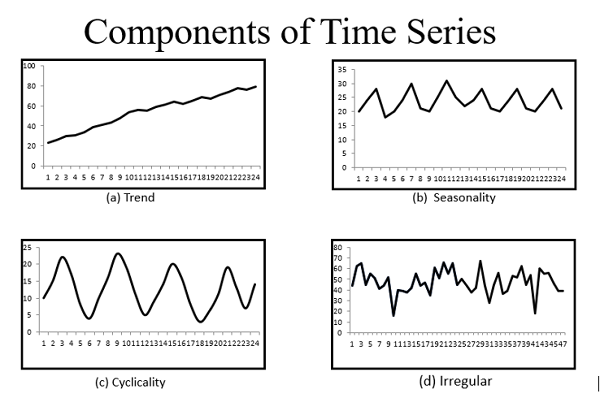

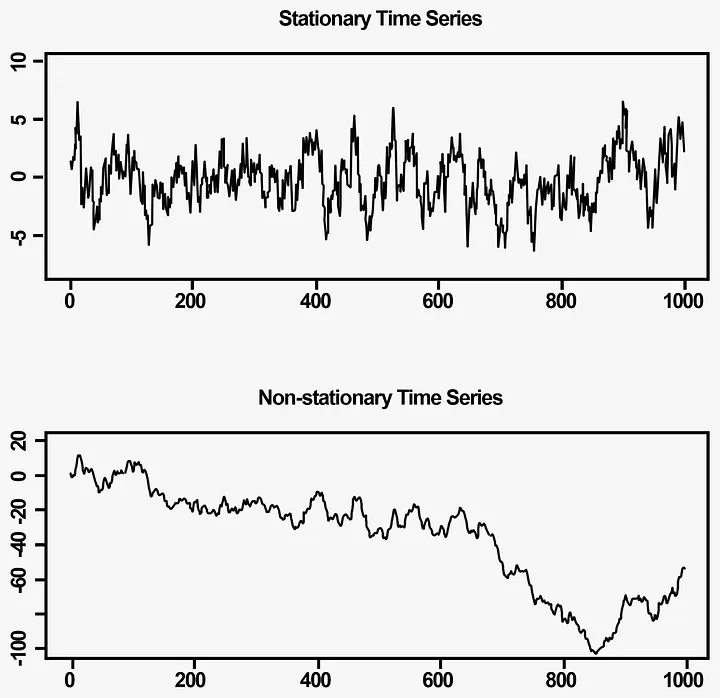

### Seasonality Check

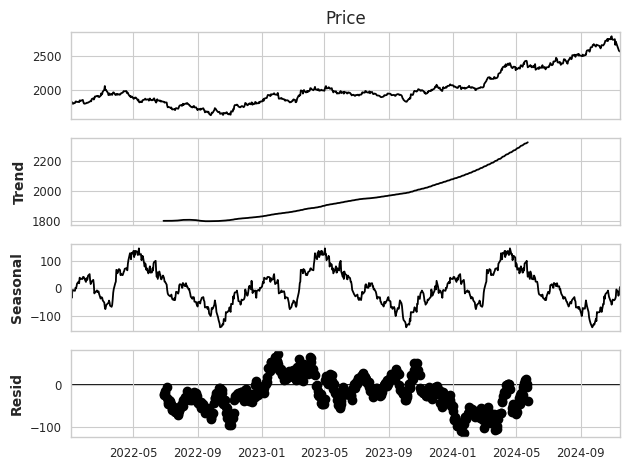

In [162]:
from statsmodels.tsa.seasonal import seasonal_decompose
#252 mean 252 trading days in year in here to captures annual seasonality
seasonal_decompose_add = seasonal_decompose(df.Price, model='additive', period=252)
df["Price_seasonal"] = seasonal_decompose_add.seasonal

seasonal_decompose_add.plot();

<Axes: xlabel='Date', ylabel='Price_seasonal'>

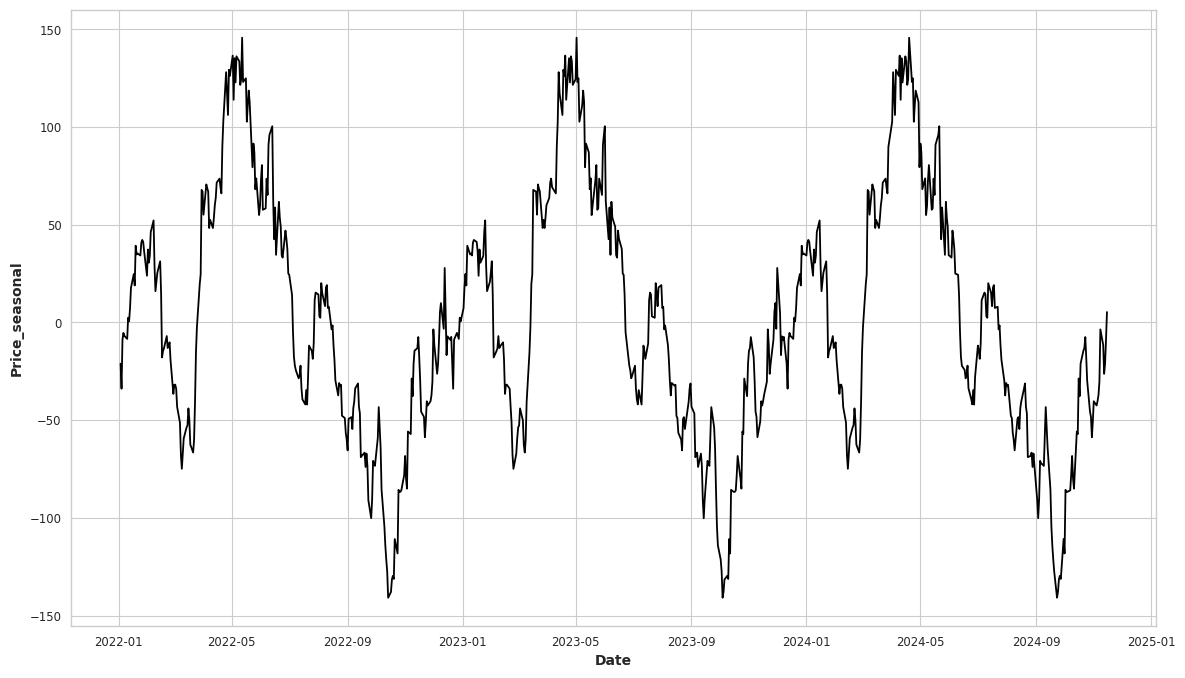

In [163]:
#plot Price_Seasonal over time
fig = plt.figure(figsize=(14,8))
sns.lineplot(x=df.index,y=df.Price_seasonal)

### Stationary :
some time-series models  such as such as ARIMA  assume that the underlying data is stationary. Stationarity describes that the time-series has

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

**The check for stationarity can be done via three different approaches:**

- **1- visually**: plot time series and check for trends or seasonality
- **2- basic statistics**: split time series and compare the mean and variance of each partition
- **3- statistical test**: Augmented Dickey Fuller test

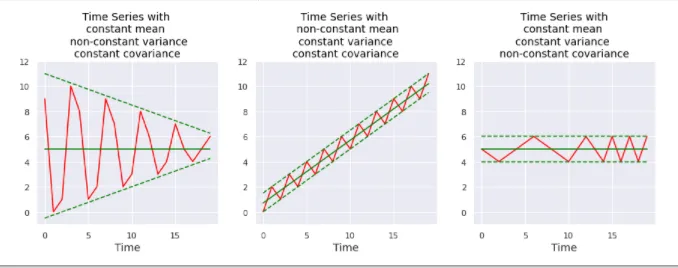


### **Augmented Dickey-Fuller (ADF) Test**
The ADF test is a statistical test used to determine whether a time series is stationary by checking for a unit root.

#### **Hypotheses**
- **Null Hypothesis (\(H_0\))**: The time series has a unit root ( it is non-stationary).
- **Alternative Hypothesis (\(H_1\))**: The time series does not have a unit root (  it is stationary).


### **Decision Rules**
1. **Using the p-value**:
   - (p > 0.05) (default significance level): Fail to reject (H_0). The series has a unit root and is non-stationary.
   - (p leq 0.05): Reject (H_0). The series does not have a unit root and is stationary.



In [164]:
from statsmodels.tsa.stattools import adfuller
### print p-value of adf test
print("P-value of ADF Test: " ,adfuller(df.Price)[1])

P-value of ADF Test:  0.9851438268047229


### visually :

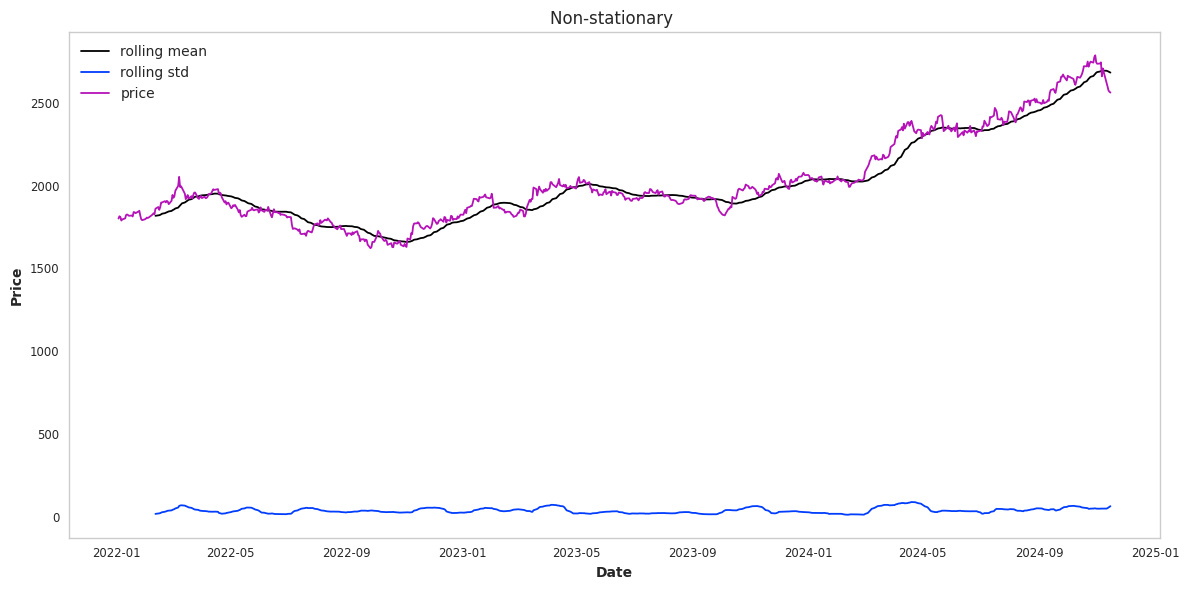

In [165]:
#check for price ( close price ) stationary
plt.figure(figsize=(12,6))

#let's get mv with 30 day rolling window
mean = df.Price.rolling(window=30).mean()
std  = df.Price.rolling(window=30).std()

sns.lineplot(x=df.index, y=mean ,label="rolling mean")
sns.lineplot(x=df.index, y=std ,label="rolling std")
sns.lineplot(x=df.index, y=df.Price ,label="price")

plt.title("Non-stationary ")
plt.grid(False)
plt.tight_layout()

### How Handle Non-Stationary Time-Series Data For Models Such as Arima :

#### **Why Stationarity Matters** :
#### Models that Require Stationarity:
- **ARIMA** (AutoRegressive Integrated Moving Average)
- **SARIMA** (Seasonal ARIMA)
- **Exponential Smoothing State Space Model (ETS)**

#### Models that Do Not Require Stationarity:
- **LSTM/GRU** (Deep learning models like Recurrent Neural Networks)
- **Prophet** (Automatically adjusts for trends and seasonality)
- **Random Forest and Gradient Boosting** (When used for regression on raw time-series features)

While non-stationary data can work with certain models, transforming it to stationary improves feature extraction, interpretability, and predictive performance for statistical methods.

---

### **How to Handle Non-Stationary Data**
Here are the primary techniques to make a series stationary:

#### **1. Differencing**
- Subtract the previous observation from the current one:
  [
  Y_t = Y_t - Y_{t-1}
  ]
- Removes trends and makes the series stationary in mean.
- If one round of differencing does not achieve stationarity higher order differencing can be applied ( Differencing again )


#### **2. Log Transformation**
- Applies logarithmic scaling to reduce variance and stabilize fluctuations in a series.
- Effective for series with exponential trends.
- Equation:
  [
  Y_t = log(Y_t)
  ]



In [166]:
#calculate diff to make all features stationary
for col in df.columns:
  df[col+"_diff"] = df[col].diff(1)

#drop first rows which is nan now
df.dropna(axis=0,inplace=True)

In [167]:
df.head()

,Price,Open,High,Low,Change %,Price_seasonal,Price_diff,Open_diff,High_diff,Low_diff,Change %_diff,Price_seasonal_diff
Date,,,,,,,,,,,,
2022-01-04,1814.56,1801.34,1816.83,1798.44,0.76,-33.902479,13.71,-28.80,-15.23,0.51,2.27,-12.794911
2022-01-05,1809.53,1814.90,1829.82,1807.97,-0.28,-8.793511,-5.03,13.56,12.99,9.53,-1.04,25.108968
2022-01-06,1788.68,1809.94,1811.89,1786.03,-1.15,-5.351924,-20.85,-4.96,-17.93,-21.94,-0.87,3.441587
2022-01-07,1795.63,1789.55,1799.20,1782.63,0.39,-6.861497,6.95,-20.39,-12.69,-3.40,1.54,-1.509573
2022-01-10,1801.41,1795.41,1802.57,1790.43,0.32,-8.433392,5.78,5.86,3.37,7.80,-0.07,-1.571895


##### Test Again with AdFuller

In [168]:
print("P-value of ADF Test: " ,adfuller(df.Price_diff)[1])

P-value of ADF Test:  3.7284476847758564e-11


##### Let's visulizae the all features with Diff

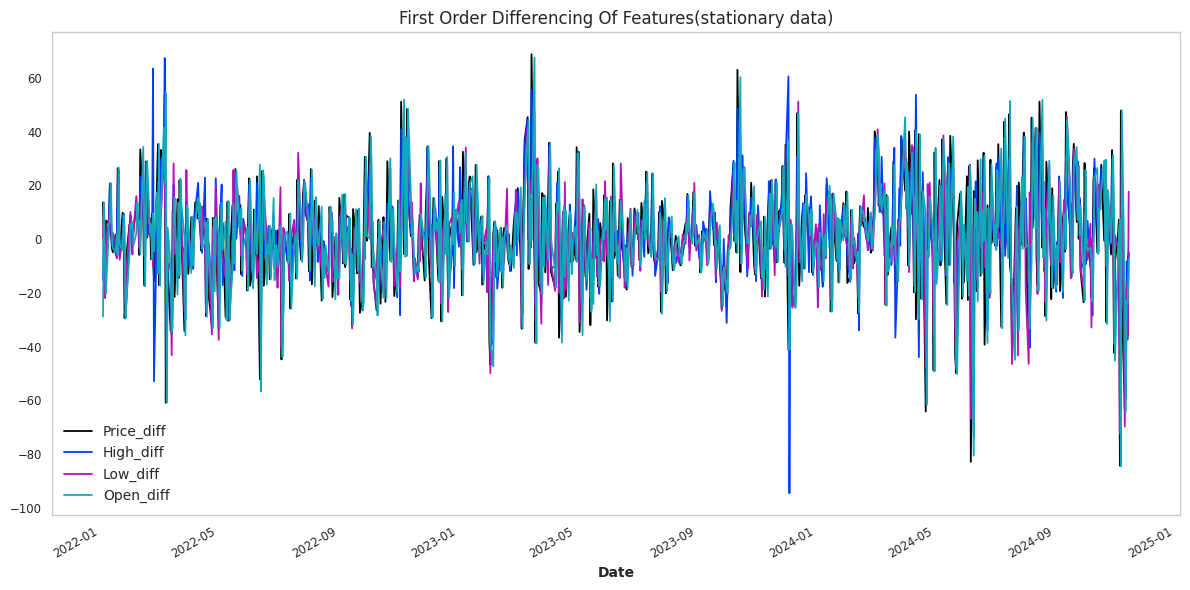

In [169]:
df.Price_diff.plot(figsize=(12,6))
df.High_diff.plot(figsize=(12,6))
df.Low_diff.plot(figsize=(12,6))
df.Open_diff.plot(figsize=(12,6))
plt.title("First Order Differencing Of Features(stationary data)")
plt.grid(False)
plt.legend()
plt.tight_layout()

# 5- Feature Enginnering :

in here our feature enineering is  creating new variables that capture relevant patterns in the data. this step improves the performance of predictive models. for stock market data  adding **lagged features** and **technical indicators** are common practices ( these features actually will be used for Sarimax and deep time-series models)


### **Lagged Features**
   - a **lagged feature** is a copy of the original feature shifted by a certain number of time steps For example:
     - Lag 1: Closing price from the previous day.
     - Lag 2: Closing price from two days ago
  
2. **Why Add Lagged Features?**
   - they help capture the influence of past observations on the current state
  
3. **How to Choose the Best Lag?**
   - **Automatically**:
     - use **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots to determine lags with the highest correlation to the target variable
   - **Fixed Approach**:
     - for financial data  commonly used lags are 1, 5, 10, or 20 days to align with daily  weekly, or monthly trends


In [170]:
#adding 1 day and 5 day lagged for all columns
base_columns = ["Price", "High", "Low", "Open"]

for col in base_columns :
  for lag in [1,5]:
    df[f"{col}_lag_{lag}"] = df[col].shift(-lag)


### **Technical Indicators Using pandas-ta**
   - Technical indicators are calculated metrics based on stock data (Open, High, Low, Close, Volume)Examples include:
     - **Moving Averages (MA)**: Smoothed price trends.
     - **Relative Strength Index (RSI)**: Measures momentum.
     - **MACD**: Tracks the convergence/divergence of moving averages

2. **Why Add Indicators?**
   - Enhance feature representation for machine learning models by summarizing complex patterns.
   - Useful for deep learning models like **LSTMs/GRUs** and regression models like **SARIMAX**.

3. **Not Useful for ARIMA**:
   - ARIMA assumes the series is stationary and uses its internal autoregressive terms, differencing, and moving averages, making external features unnecessary.


In [171]:
#we just use sma in this project as new indicator feature
# adding sma 9 and 13 for each ohld features
for col in ["Price"]:
  for sma in [9,13]:
    df[f"{col}_sma_{sma}"] = ta.sma(df[col], length=sma)

In [172]:
df.head()

,Price,Open,High,Low,Change %,Price_seasonal,Price_diff,Open_diff,High_diff,Low_diff,Change %_diff,Price_seasonal_diff,Price_lag_1,Price_lag_5,High_lag_1,High_lag_5,Low_lag_1,Low_lag_5,Open_lag_1,Open_lag_5,Price_sma_9,Price_sma_13
Date,,,,,,,,,,,,,,,,,,,,,,
2022-01-04,1814.56,1801.34,1816.83,1798.44,0.76,-33.902479,13.71,-28.80,-15.23,0.51,2.27,-12.794911,1809.53,1822.01,1829.82,1823.35,1807.97,1800.09,1814.90,1801.69,NaN,NaN
2022-01-05,1809.53,1814.90,1829.82,1807.97,-0.28,-8.793511,-5.03,13.56,12.99,9.53,-1.04,25.108968,1788.68,1825.32,1811.89,1828.33,1786.03,1814.20,1809.94,1822.49,NaN,NaN
2022-01-06,1788.68,1809.94,1811.89,1786.03,-1.15,-5.351924,-20.85,-4.96,-17.93,-21.94,-0.87,3.441587,1795.63,1822.09,1799.20,1828.38,1782.63,1811.83,1789.55,1825.94,NaN,NaN
2022-01-07,1795.63,1789.55,1799.20,1782.63,0.39,-6.861497,6.95,-20.39,-12.69,-3.40,1.54,-1.509573,1801.41,1817.22,1802.57,1829.66,1790.43,1814.13,1795.41,1822.55,NaN,NaN
2022-01-10,1801.41,1795.41,1802.57,1790.43,0.32,-8.433392,5.78,5.86,3.37,7.80,-0.07,-1.571895,1822.01,1818.99,1823.35,1823.72,1800.09,1812.67,1801.69,1817.90,NaN,NaN


# 6- EDA : Exploratory Data Analysis

###  Autocorrelation Analysis

After making a time series stationary ( by differencing), the next step in building an ARIMA model is to decide whether **AR (autoregressive)** or **MA (moving average)** terms are needed. This is done using **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots


1. **ACF Plot**:
   - Shows how strongly current values in the series are related to lagged values.
   - Helps identify **MA (Moving Average)** terms by observing patterns in autocorrelation at different lags.
   - Example: If the ACF plot shows significant spikes up to lag 3, you might include 3 MA terms in the model.
   
2. **PACF Plot**:
   - Highlights the direct relationship between current values and specific lagged values, removing the influence of intermediate lags.
   - Helps determine **AR (Autoregressive)** terms.
   - Example: Significant PACF spikes at lag 2 suggest using 2 AR terms.



In [173]:
from statsmodels.tsa.stattools import acf, pacf

acf_values = acf(df['Price_diff'], nlags=20)
pacf_values = pacf(df['Price_diff'], nlags=20)

print("ACF Values:")
print(acf_values)
print("\nPACF Values:")
print(pacf_values)

ACF Values:
[ 1.00000000e+00 -4.43840680e-02 -4.63570103e-02  5.19703584e-02
  7.63029704e-02  1.87157075e-02  2.61654620e-02 -4.08078692e-03
 -2.08307036e-02  4.54244157e-03 -7.25886489e-02 -1.95751453e-02
 -2.30440419e-03  6.76905887e-02 -4.98672161e-02 -5.36899626e-02
 -8.88343760e-02  1.99582598e-04  2.34659221e-02 -7.96460850e-03
  1.65229730e-02]

PACF Values:
[ 1.         -0.04444356 -0.04855259  0.04806398  0.07953425  0.03108936
  0.03357612 -0.00719319 -0.02826259 -0.005684   -0.08186579 -0.02640121
 -0.00851096  0.07811192 -0.02729895 -0.04481798 -0.10456283 -0.02265445
  0.01914835  0.0100902   0.03801706]


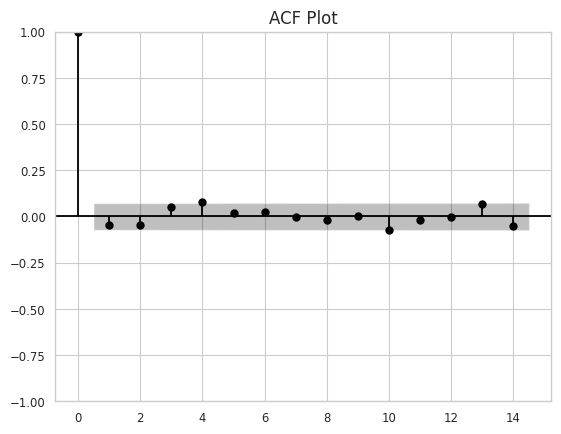

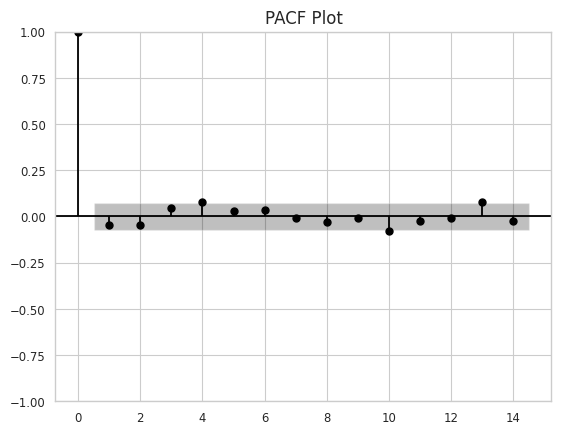

In [174]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Price_diff'], lags=14)
plt.title('ACF Plot')
plt.show()


plot_pacf(df['Price_diff'], lags=14)
plt.title('PACF Plot')
plt.show()


#### **Interpretation of Plots**:
Both plots indicate that the differenced series does not exhibit meaningful autocorrelation or partial autocorrelation at higher lags and this suggests that the series has been sufficiently differenced and lacks strong dependence structures that are typical of AR or MA processes.

since the ACF and PACF do not show significant spikes it is unlikely that additional AR (Autoregressive) or MA (Moving Average) terms will meaningfully improve the model. the data may already behave like white noise meaning it is hard to model and **ARIMA Will Not Usefull Here**

# 7-Statistical Models (ARIMA and SARIMAX)

### Time series can be either univariate or multivariate:

- **Univariate**:  time series only has a single time-dependent variable such as Arima (just base on Close Price)
- **Multivariate**: time series have a multiple time-dependent variable ( like SARIMAX and Deep Models )

### Split Train Test Data For Univariate Time-Seris and Arima

In [175]:
X = df.index
y = df['Price']

#get last month for test
SPLIT_INDEX =30

X_train,X_test = X[:-SPLIT_INDEX],X[-SPLIT_INDEX:]
y_train,y_test = y[:-SPLIT_INDEX],y[-SPLIT_INDEX:]

<Axes: xlabel='Date', ylabel='Price'>

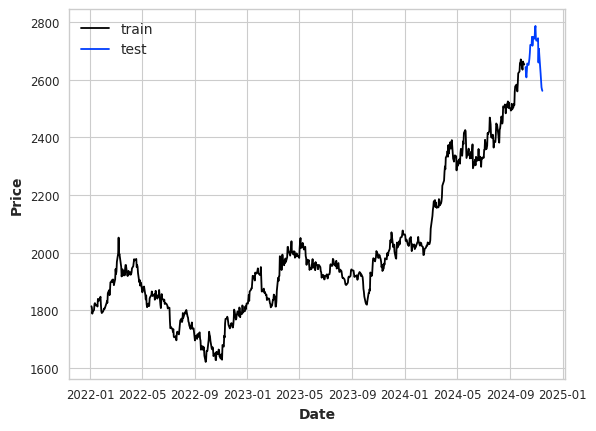

In [176]:
sns.lineplot(
    x=X_train,
    y=y_train,
    label="train"
)
sns.lineplot(
    x=X_test,
    y=y_test,
    label="test"
)

### 7.1- Arima Model

#### Train Model

In [177]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

### ARIMA( p, d, q) PARAMTERS :
### p: Lag order
### d: Degree of differencing
### q: Order of moving average

#train model
model = ARIMA(y_train, order=(1,1,1))
fitted_model = model.fit()

#prediction next 30 day
y_pred  = fitted_model.forecast(30)

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  717
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3084.700
Date:                Sun, 24 Nov 2024   AIC                           6175.400
Time:                        16:53:58   BIC                           6189.121
Sample:                             0   HQIC                          6180.698
                                - 717                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2403      0.719      0.334      0.738      -1.168       1.649
ma.L1         -0.2851      0.707     -0.403      0.687      -1.670       1.100
sigma2       323.0981     13.113     24.639      0.000     297.397     348.799
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                60.10
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Model Evaluation

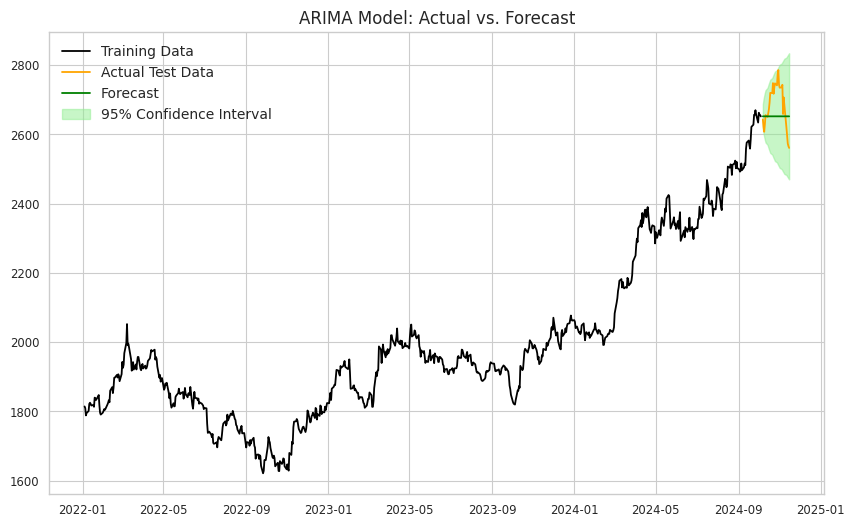

In [178]:
forecast = fitted_model.get_forecast(steps=len(y_test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)


plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='orange')
plt.plot(y_test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(y_test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen',
                 alpha=0.5,
                 label='95% Confidence Interval')
plt.legend()
plt.title('ARIMA Model: Actual vs. Forecast')
plt.show()

#### AS you can see it's not useful at all in here

### 7.2 SARIMAX

### Train/Test Split

#### Let See What Features we have to use for   Multivariate Models

In [179]:
df.dropna(axis=0,inplace=True)

In [180]:
 = ['Open_lag_1', #previous day open price
                      'High_lag_1', #previous day high price
                      'Low_lag_1',        #previous day low price
                      'Price_lag_5',
                      'Price_sma_9',
                      'Price_sma_13',
                      ]
target = 'Price'

In [181]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


test_size = 30
y = df[target]
X = df[exogenous_features]  # exogenous features

#split train test
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

#### Train Model

In [182]:
#parameters
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  #(P, D, Q, S)

#train
model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit(disp=False)

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  700
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1376.835
Date:                            Sun, 24 Nov 2024   AIC                           2775.670
Time:                                    16:54:14   BIC                           2825.526
Sample:                                         0   HQIC                          2794.959
                                            - 700                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Open_lag_1       0.9891      0.010    102.341      0.000       0.970       1.008
High_lag_1       0.0063      0.009      0.698      0.485      -0.011       0.024
Low_lag_1        0.0055      0.008      0.681      0.496      -0.010       0.021
Price_lag_5     -0.0032      0.002     -1.341      0.180      -0.008       0.001
Price_sma_9      0.0088      0.010      0.840      0.401      -0.012       0.029
Price_sma_13    -0.0080      0.010     -0.785      0.433      -0.028       0.012
ar.L1           -0.1544      0.036     -4.284      0.000      -0.225      -0.084
ma.L1           -0.8787      0.022    -39.586      0.000      -0.922      -0.835
ar.S.L12        -0.0360      0.017     -2.097      0.036      -0.070      -0.002
ma.S.L12        -0.8528      0.028    -29.933      0.000      -0.909      -0.797
sigma2           3.0658      0.082     37.523      0.000       2.906       3.226
===================================================================================
Ljung-Box (L1) (Q):                   2.94   Jarque-Bera (JB):            205049.70
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -4.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        87.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Model Evaluation

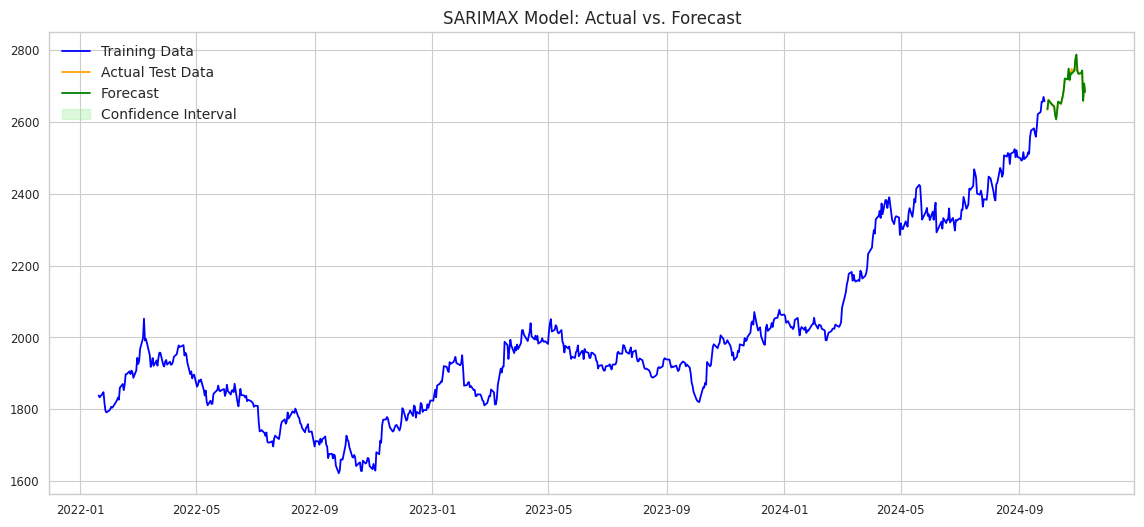

In [183]:

forecast = fitted_model.get_forecast(steps=test_size, exog=X_test)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='orange')
plt.plot(y_test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('SARIMAX Model: Actual vs. Forecast')
plt.show()


# 8- Deep Learning Models ( with Help Of Darts Library)

In [257]:
def plot_predictions(test, prediction, scaler, title):
    plt.figure(figsize=(14, 6))
    actual = scaler.inverse_transform(test)
    pred = scaler.inverse_transform(prediction)

    actual.plot(label='Actual')
    pred.plot(label='Model Prediction')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(test, prediction):
    metrics = {
        'MAPE': mape(test, prediction),
        'RMSE': rmse(test, prediction),
        'MAE': mae(test, prediction)
    }
    return pd.DataFrame([metrics])

#### Split Train/Test Data For Deep Models

In [254]:
df = df.asfreq('B')
df["Date"] = df.index.copy()

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [187]:
def prepare_data(df, target_col, test_size):
    series = TimeSeries.from_dataframe(df, value_cols=target_col)
    scaler = Scaler()
    series_scaled = scaler.fit_transform(series)

    train = series_scaled[:-test_size]
    test = series_scaled[-test_size:]

    return train, test, scaler

In [281]:
def prepare_ohlc_data(df, feature_cols, target_col, test_size=30, timesteps=6):

    series_features = TimeSeries.from_dataframe(
        df,
        value_cols=feature_cols,
    )

    series_target = TimeSeries.from_dataframe(
        df,
        value_cols=target_col,
    )

    #scale data
    scaler_features = Scaler()
    scaler_target = Scaler()

    series_features_scaled = scaler_features.fit_transform(series_features)
    series_target_scaled = scaler_target.fit_transform(series_target)

    #split data
    train_target = series_target_scaled[:-test_size]
    test_target = series_target_scaled[-test_size:]


    train_features = series_features_scaled[:-test_size]
    test_features = series_features_scaled[-test_size:]

    return (train_features, test_features, train_target, test_target,
            scaler_features, scaler_target)

In [282]:
timesteps = 6
test_size = 30

(train_features, test_features, train_target, test_target,
 scaler_features, scaler_target) = prepare_ohlc_data(
    df,
    exogenous_features,
    target,
    timesteps=timesteps,
    test_size=test_size
)

### 8.1 NBEATs Model

#### Train Model

In [ ]:
model = NBEATSModel(
      input_chunk_length=timesteps,
      output_chunk_length=1,
      generic_architecture=True,
      num_stacks=2,
      num_blocks=3,
      num_layers=4,
      layer_widths=512,
      n_epochs=10,
      random_state=42
  )

model.fit(series=train_target,past_covariates=train_features, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.9 M  | train
-------------------------------------------------------------
4.9 M     Trainable params
2.8 K     Non-trainable params
4.9 M     Total params
19.570    Total estimated model params size (MB)
76        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=2, num_blocks=3, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=6, output_chunk_length=1, n_epochs=10, random_state=42)

#### Prediction

In [ ]:
predictions = []
historical_target = train_target
historical_features = train_features

#forecast loop
for i in range(len(test_target)):
    #one step prediction
    pred = model.predict(
        n=1,
        series=historical_target,
        past_covariates=historical_features
    )
    predictions.append(pred)

    #update historical data for next prediction
    historical_target = historical_target.append(pred)
    if i < len(test_features):
        historical_features = historical_features.append(test_features[i:i+1])

#all predictions
prediction = predictions[0]
for p in predictions[1:]:
    prediction = prediction.append(p)

#### Model Evaluation

In [287]:
print("Prediction shape:", prediction.shape)
print("Test target shape:", test_target.shape)

Prediction shape: (30, 1, 1)
Test target shape: (30, 1, 1)


#### Metrics

In [288]:
metrics = evaluate_model(test_target, prediction)
metrics

,MAPE,RMSE,MAE
0,1.130635,0.013909,0.010414


#### Plot Prediction VS Real

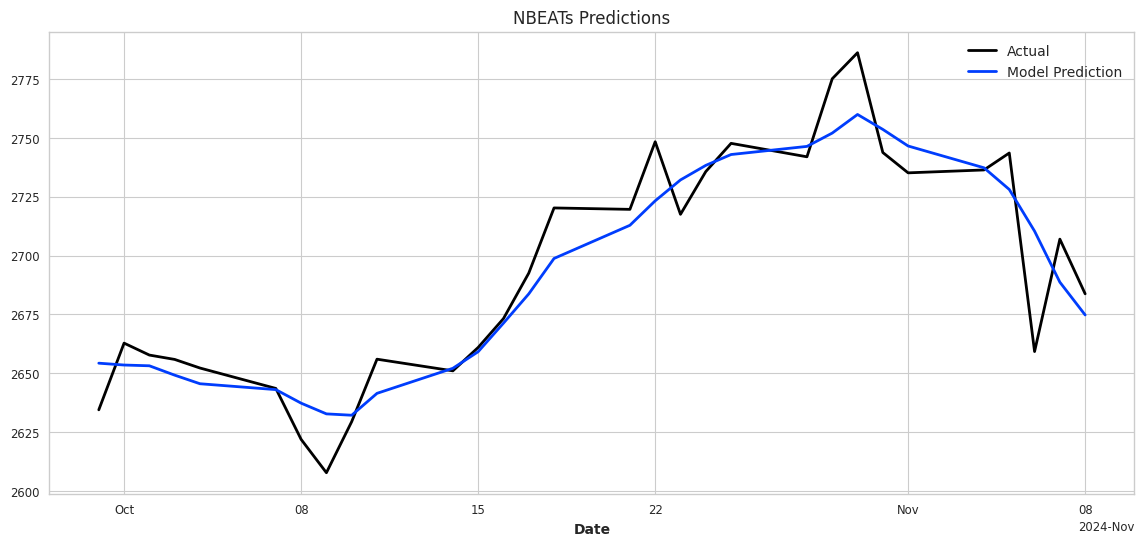

In [289]:
plot_predictions(test_target, prediction, scaler_target,"NBEATs Predictions")

### 8.2 TCN Model

#### Train Model

In [291]:
model = TCNModel(
    input_chunk_length=timesteps,
    output_chunk_length=1,
    kernel_size=3,
    num_filters=64,
    num_layers=2,
    weight_norm=True,
    dropout=0.1,
    batch_size=16,
    n_epochs=10,
    random_state=42
)

model.fit(series=train_target,past_covariates=train_features, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 27.1 K | train
-------------------------------------------------------------
27.1 K    Trainable params
0         Non-trainable params
27.1 K    Total params
0.108     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=64, num_layers=2, dilation_base=2, weight_norm=True, dropout=0.1, input_chunk_length=6, output_chunk_length=1, batch_size=16, n_epochs=10, random_state=42)

#### Prediction

In [292]:
predictions = []
historical_target = train_target
historical_features = train_features

#forecast loop
for i in range(len(test_target)):
    #one step prediction
    pred = model.predict(
        n=1,
        series=historical_target,
        past_covariates=historical_features
    )
    predictions.append(pred)

    #update historical data for next prediction
    historical_target = historical_target.append(pred)
    if i < len(test_features):
        historical_features = historical_features.append(test_features[i:i+1])

#all predictions
prediction = predictions[0]
for p in predictions[1:]:
    prediction = prediction.append(p)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

#### Model Evaluation

In [293]:
print("Prediction shape:", prediction.shape)
print("Test target shape:", test_target.shape)

Prediction shape: (30, 1, 1)
Test target shape: (30, 1, 1)


#### Metrics

In [294]:
metrics = evaluate_model(test_target, prediction)
metrics

,MAPE,RMSE,MAE
0,2.696025,0.028473,0.025078


#### Plot Prediction VS Real

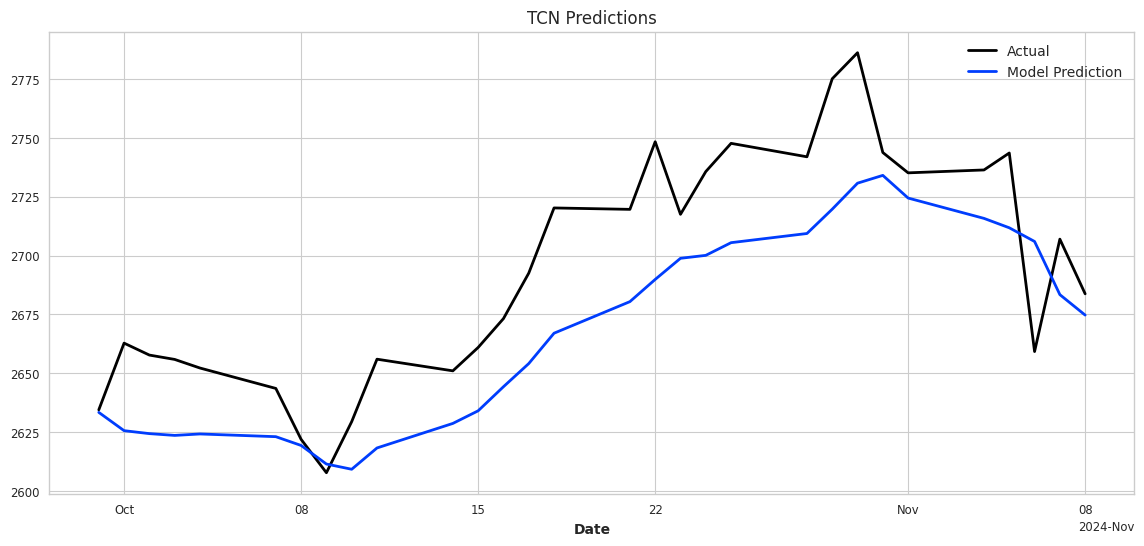

In [295]:
plot_predictions(test_target, prediction, scaler_target,"TCN Predictions")

### 8.3 Transformer Model

#### Train Model

In [301]:
model = TransformerModel(
      input_chunk_length=timesteps,
      output_chunk_length=1,
      d_model=64,
      nhead=4,
      num_encoder_layers=3,
      num_decoder_layers=3,
      dim_feedforward=512,
      dropout=0.1,
      batch_size=16,
      n_epochs=20,
      random_state=42
  )
model.fit(series=train_target,past_covariates=train_features, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 512    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 65     | train
-------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=6, output_chunk_length=1, batch_size=16, n_epochs=20, random_state=42)

#### Prediction

In [302]:
predictions = []
historical_target = train_target
historical_features = train_features

#forecast loop
for i in range(len(test_target)):
    #one step prediction
    pred = model.predict(
        n=1,
        series=historical_target,
        past_covariates=historical_features
    )
    predictions.append(pred)

    #update historical data for next prediction
    historical_target = historical_target.append(pred)
    if i < len(test_features):
        historical_features = historical_features.append(test_features[i:i+1])

#all predictions
prediction = predictions[0]
for p in predictions[1:]:
    prediction = prediction.append(p)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

#### Model Evaluation

In [303]:
print("Prediction shape:", prediction.shape)
print("Test target shape:", test_target.shape)

Prediction shape: (30, 1, 1)
Test target shape: (30, 1, 1)


#### Metrics

In [304]:
metrics = evaluate_model(test_target, prediction)
metrics

,MAPE,RMSE,MAE
0,2.939214,0.032911,0.026267


#### Plot Prediction VS Real

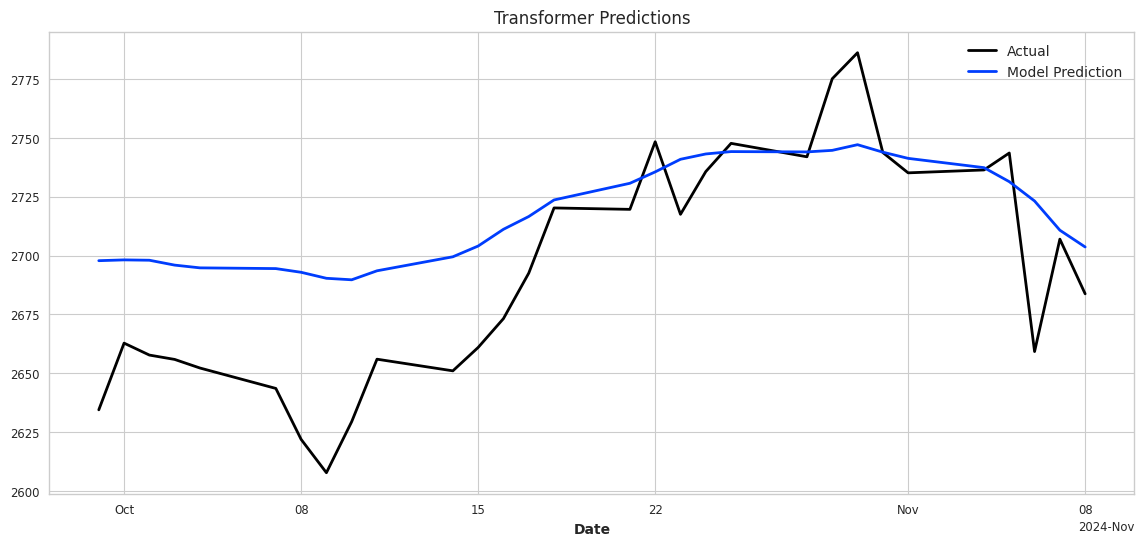

In [305]:
plot_predictions(test_target, prediction, scaler_target,"Transformer Predictions")